In [1]:
%reset -sf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import cv2
import glob
import os
from scipy import ndimage
from PIL import Image

In [3]:
nH=512
nW=256

In [4]:
img_dir="C:/Users/Reza/Desktop/Deep learning/project/u-net segmentation/Image-Segmentation-with-Tensorflow-master/Carvana Image Masking Challenge (kaggle)/train/"
mask_dir="C:/Users/Reza/Desktop/Deep learning/project/u-net segmentation/Image-Segmentation-with-Tensorflow-master/Carvana Image Masking Challenge (kaggle)/train_masks/"

def file_names():
    
    file_name=[]
    names=glob.glob(img_dir+"*.jpg")
    
    for name in names:
        file_name.append(os.path.basename(name).split(".")[0])

    return file_name

In [5]:
file_name=file_names()
shuffel_index= np.random.permutation(len(file_name))

def batch_image(batch_size,batch_num):
    img_batch=[]
    mask_batch=[]
    
    
    for i in range(batch_size):
        img=Image.open(img_dir+str(file_name[shuffel_index[batch_size*batch_num+i]])+".jpg").convert("L")
        img=np.array(img.resize((nH,nW),Image.BICUBIC))
        img=np.expand_dims(img,axis=3)
        img=img/255.
        img_batch.append(img)
        
        mask=Image.open(mask_dir+str(file_name[shuffel_index[batch_size*batch_num+i]])+"_mask.gif").convert("L")
        mask=np.array(mask.resize((nH,nW),Image.BICUBIC))
        mask=np.expand_dims(mask,axis=2)
        mask=mask/255.
        mask1=1.-mask
        mask=np.concatenate((mask,mask1),axis=2)
        mask_batch.append(mask)

    
    return img_batch, mask_batch

In [6]:
tf.reset_default_graph()
input_x = tf.placeholder(tf.float32, [None, None, None, 1])
input_y = tf.placeholder(tf.float32, [None, None, None, 2])
train= tf.placeholder(tf.bool)

In [7]:
def pool(inputs):
    pooled = tf.layers.max_pooling2d(inputs=inputs, pool_size=[2, 2], strides=2)
    return pooled

In [8]:
def conv2d(input_layer,filter_num,filter_size,drop_rate,padding='valid',train=True):
    
    conv_layer=tf.layers.conv2d(inputs=input_layer,filters=filter_num,kernel_size=filter_size,
                                padding=padding, activation=tf.nn.relu,
                                kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                bias_initializer=tf.constant_initializer(0.1))
    
    batch_norm=tf.layers.batch_normalization(conv_layer,training=train)
    
    return batch_norm

In [9]:
def conv2d_transpose(input_layer,filter_num,filter_size,drop_rate,stride,padding='valid',train=True):
    
    deconv_layer=tf.layers.conv2d_transpose(inputs=input_layer,filters=filter_num,
                                            kernel_size=filter_size,
                                            strides=2,padding=padding, activation=tf.nn.relu)
    
    return deconv_layer

In [10]:
def down_layer(input_layer,filter_num,filter_size,drop_rate,padding='same',train=True):
    
    layer1=conv2d(input_layer,filter_num,filter_size,drop_rate,padding=padding,train=True)
    layer2=conv2d(layer1,filter_num,filter_size,drop_rate,padding=padding,train=True)
    
    return layer2

In [11]:
def up_layer(input_layer,filter_num,filter_size,dropout_rate,padding='same',train=True):
    
    layer1=conv2d(input_layer,filter_num,filter_size,dropout_rate,padding=padding,train=True)
    layer2=conv2d(layer1,filter_num,filter_size,dropout_rate,padding=padding,train=True)
    
    return layer2

In [12]:
def layer_level(previous_layer,filter_num,filter_size,dropout_rate,stride,layer_num,pad='valid',train=True):
    
    if(layer_num>0):
        current_layer_down= down_layer(previous_layer,filter_num,filter_size,dropout_rate,pad,train)
        current_layer =tf.layers.max_pooling2d(inputs=current_layer_down,pool_size=2,strides=2,padding=pad)
        current_layer = layer_level(current_layer,(filter_num*2),filter_size,dropout_rate,stride,(layer_num-1),pad,True)
        current_layer = tf.concat([current_layer_down,current_layer], 3)    
    
    if (layer_num==0): 
        current_layer = up_layer(previous_layer,filter_num,filter_size,dropout_rate,pad,train)
    else:
        current_layer = up_layer(current_layer,filter_num,filter_size,dropout_rate,pad,train)
    
    if(layer_num<4):
        current_layer = conv2d_transpose(current_layer,filter_num//2,filter_size,dropout_rate,stride,pad,True)
       
        
    return current_layer

In [13]:
def one_by_one(input_layer,filter_num,filter_size,drop_rate,pad='valid',train=True):
    
    fully_con= tf.layers.conv2d(inputs=input_layer,filters=filter_num,kernel_size=filter_size,
                                padding=pad)
    
    return fully_con

In [14]:
filter_num=16
filter_size=3
dropout_rate=0.0
stride=1
layer_num=4
pad='same'

def my_unet(input_layer):
    
    final= layer_level(input_layer,filter_num,filter_size,dropout_rate,stride,layer_num,pad)
    output= one_by_one(final,2,1,drop_rate=0.0,pad=pad,train=train)
    
    return output

In [15]:
starter_learning_rate = 0.004
n_iteration=200

sess = tf.Session()
with tf.variable_scope("net") as scope:
    logits = my_unet(input_x)
    out=tf.nn.sigmoid(logits)
    
labels = input_y
flat_logits = tf.reshape(logits, [-1, 2])
flat_labels = tf.reshape(labels, [-1, 2])

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels))

global_step = tf.train.get_or_create_global_step()
learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                           global_step,n_iteration, decay_rate=0.5, staircase=False)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=loss)
    
sess.run(tf.global_variables_initializer())

In [16]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

for epoch in range(200):
    x_train, y_train = batch_image(16,epoch)
    
    with tf.control_dependencies(extra_update_ops):
        _, iter_loss = sess.run((optimizer, loss), feed_dict={input_x: x_train,
                                                              input_y: y_train,
                                                              train: "True"})
    if epoch%10 == 0:
        print("iter loss = ", iter_loss)
        
x_test, y_test = batch_image(16,300)
x = sess.run(out, feed_dict={input_x: x_test, 
                                input_y: y_test,
                                train: "False"})

iter loss =  0.985627
iter loss =  0.202392
iter loss =  0.146447
iter loss =  0.0932917
iter loss =  0.12774
iter loss =  0.0655516
iter loss =  0.0604828
iter loss =  0.0631788
iter loss =  0.0571701
iter loss =  0.0512672
iter loss =  0.0331802
iter loss =  0.041365
iter loss =  0.0387121
iter loss =  0.0335336
iter loss =  0.030226
iter loss =  0.027532
iter loss =  0.0270875
iter loss =  0.0230564
iter loss =  0.0257647
iter loss =  0.0221792


Text(0.5,1,'Prediction')

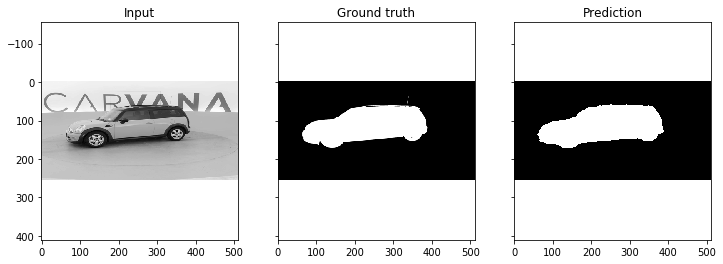

In [34]:
ff=x_test[0]
ff1=y_test[0]
mask=x[0]>0.4
fig, ax= plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
ax[0].imshow(ff[:,:,0], cmap='gray')
ax[1].imshow(ff1[:,:,0], cmap='gray')
ax[2].imshow(mask[:,:,0], cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")

In [35]:
sess.close()